In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

#DATA-PREPARATION STEP

# Considering only a quarter of the input in order to speed up the computation 
# and try to tune hyperparameters using 3-fold CrossValidation

images = np.loadtxt("handwritten_digits_images.csv", delimiter=',')
labels = np.loadtxt("handwritten_digits_labels.csv", delimiter=',')

X_train, X_test, y_train, y_test = train_test_split(images, labels,test_size=0.3, random_state=32)

# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
X_train /= 255
X_test /= 255

#Without normalization we will get an accuracy about 40%, whit it about 97%


Using TensorFlow backend.


Number of images in X_train (49000, 784)
Number of images in X_test (21000, 784)


In [2]:
#When you wrap your neural network in a Keras Classifier/Regressor, Keras can takes a multiclass [0,1,2,1] 
#and transform it into categorical representation [[0,0,0],[0,1,0],[0,0,1],[0,1,0]] just for the NN model fit. 
#So the hot encoding is not needed.

def make_model():
    
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))                            
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')    
    
    return model


def tuning(X_train,Y_train,X_test,Y_test):

    batch_size = [50, 80, 100, 128, 135, 150]
    epochs = [15,20,25]
    param_grid = dict(batch_size=batch_size, nb_epoch=epochs)

    k_model = KerasClassifier(build_fn=make_model, verbose=0)
   
    clf = GridSearchCV(estimator=k_model, param_grid=param_grid, 
                                   cv=3,
                                   scoring="accuracy", verbose=0 ,n_jobs=-1)
    clf.fit(X_train,Y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    
    model=make_model()
    
    return clf,model
    
clf = tuning(X_train,y_train,X_test,y_test)

Best parameters set found on development set:

{'batch_size': 50, 'nb_epoch': 15}


In [3]:
model = clf[1]

#Now we are not wrapping our nn into KerasClassifier so we need hot encoding
y_train_enc = np_utils.to_categorical(y_train, 10)
y_test_enc = np_utils.to_categorical(y_test, 10)

history = model.fit(X_train,y_train_enc, batch_size=50, epochs=15 ,verbose=2,validation_data=(X_test, y_test_enc))

Train on 49000 samples, validate on 21000 samples
Epoch 1/15
 - 4s - loss: 0.2527 - acc: 0.9254 - val_loss: 0.1411 - val_acc: 0.9584
Epoch 2/15
 - 4s - loss: 0.1125 - acc: 0.9663 - val_loss: 0.1080 - val_acc: 0.9665
Epoch 3/15
 - 4s - loss: 0.0770 - acc: 0.9762 - val_loss: 0.0952 - val_acc: 0.9713
Epoch 4/15
 - 4s - loss: 0.0597 - acc: 0.9809 - val_loss: 0.0828 - val_acc: 0.9743
Epoch 5/15
 - 4s - loss: 0.0475 - acc: 0.9848 - val_loss: 0.0825 - val_acc: 0.9757
Epoch 6/15
 - 4s - loss: 0.0372 - acc: 0.9882 - val_loss: 0.0724 - val_acc: 0.9780
Epoch 7/15
 - 4s - loss: 0.0302 - acc: 0.9902 - val_loss: 0.0743 - val_acc: 0.9780
Epoch 8/15
 - 4s - loss: 0.0252 - acc: 0.9919 - val_loss: 0.0764 - val_acc: 0.9770
Epoch 9/15
 - 4s - loss: 0.0232 - acc: 0.9923 - val_loss: 0.0822 - val_acc: 0.9779
Epoch 10/15
 - 4s - loss: 0.0214 - acc: 0.9927 - val_loss: 0.0718 - val_acc: 0.9809
Epoch 11/15
 - 4s - loss: 0.0188 - acc: 0.9938 - val_loss: 0.0760 - val_acc: 0.9791
Epoch 12/15
 - 4s - loss: 0.0157 - 

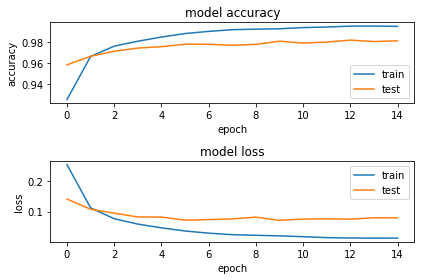


Test Loss 0.08005265406304915
Test Accuracy 0.9812857142857143


In [4]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

plt.show()

#Evaluating the model

loss, accuracy = model.evaluate(X_test, y_test_enc, verbose=2)

print()
print("Test Loss", loss)
print("Test Accuracy", accuracy)

In [5]:
predicted_classes = model.predict_classes(X_test)

# see which we predicted correctly and which not ----- Indices of elements that are non-zero.

correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

error_rate = len(incorrect_indices)/(len(correct_indices)+len(incorrect_indices))

print()
print("Error rate : ", round(error_rate*100, 2), "%")


20607  classified correctly
393  classified incorrectly

Error rate :  1.87 %
